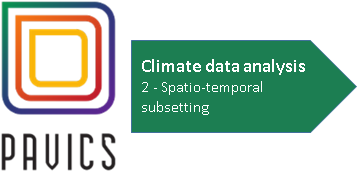

In this second tutorial we will demonstate PAVICS subsetting tools, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS subsetting relies on the `clisops` library enabling data extraction by:
* Point location(s) 
* Bounding box 
* Polygon
* Time range

*NOTE : to run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*
___
*Further documentation for python libraries used in this tutorial:<br />
**clisops** https://clisops.readthedocs.io/en/latest/notebooks/core_subset.html<br />

For convenience the `clisops.core.subset`module is also currently exposed in Ouranos' xclim library via `xclim.subset`*
___

#### Tutorial preparation : We will re-use part of the data-access tutorial to create a list of the cb-oura-1.0 datasets from the PAVICS THREDDS server

'Successfully found 11 datasets for rcp45'

'Successfully found 11 datasets for rcp85'

,Array,Chunk
Bytes,164.20 GB,59.96 MB
Shape,"(55115, 700, 1064)","(322, 175, 266)"
Count,2753 Tasks,2752 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,164.20 GB,59.96 MB
Shape,"(55115, 700, 1064)","(322, 175, 266)"
Count,2753 Tasks,2752 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


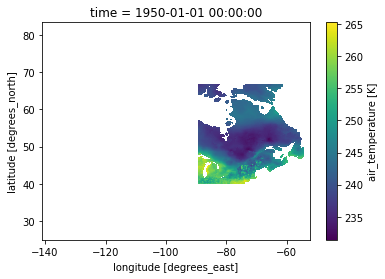

In [101]:
import threddsclient
import xarray as xr
from IPython.display import display
# cb-oura-1.0 thredds catalog url
url = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.html'

#create a simple search sub-function
def get_ncfilelist(pattern, expected, url):
    
    ## crawl a thredds catalog and filter results for dataset names containing a string pattern 
    
    datasets = [ds for ds in threddsclient.crawl(url)]   # list of all datasets 
    ncfiles = [ds for ds in datasets if pattern in ds.name]  # filter 
       
    ## Validate that the number of results is equal to the provided expected number
    if len(ncfiles) == expected:
        display(f"Successfully found {expected} datasets for {pattern}")
        return ncfiles
    else:
        raise ValueError(f'Expected number of datasets for {pattern} is {expected} : found {len(ncfiles)}')

# call the sub-function in a loop searching for RCP 4.5 and 8.5 datasets
datasets = {}
for r in ['rcp45','rcp85']:
    expected = 11
    datasets[r] = get_ncfilelist(r, expected, url)

# create a single datasets for the subsetting demo
ds = xr.open_dataset(datasets['rcp45'][0].opendap_url(), chunks='auto')
display(ds)
ds.tasmin.isel(time=0).plot()

___
### Subsetting point location(s) : `subset.subset_gridpoint()`

#### Extract the closest gridcell

In [102]:
#import subset module 
from clisops.core import subset
ds_gridpoint = subset.subset_gridpoint(ds, lon=-75.4, lat =46.67)
ds_gridpoint

,Array,Chunk
Bytes,220.46 kB,1.29 kB
Shape,"(55115,)","(322,)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,220.46 kB,1.29 kB
Shape,"(55115,)","(322,)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


#### Extract multiple locations
* Multiple locations can be extracted by sending in a list of latitude and longitude values
* The output will include a new `site` dimension

In [79]:
lon=[-75.4, -85, -65.5]
lat=[46.67, 41, 55.3]
ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat=lat)
ds_gridpoint

,Array,Chunk
Bytes,661.38 kB,3.86 kB
Shape,"(55115, 3)","(322, 3)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,661.38 kB,3.86 kB
Shape,"(55115, 3)","(322, 3)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


#### Add a distance coordinate
As `subset_gridpoint`extracts the closest gridcell to the provided locaiton (based on grid centroid coordinates) it can sometimes be useful to add a distance coordinate to the output by using the `add_distance` parameter. This additonal coordinate indicates the distance (m) between the provided point location and the selected gridcell's centroid 

In [103]:
ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat =lat, add_distance=True)
for s in ds_gridpoint.site:
    print(f"lon, lat, distance : {ds_gridpoint.sel(site=s).lon.values},{ds_gridpoint.sel(site=s).lat.values}, {ds_gridpoint.sel(site=s).distance.values}" )
    

lon, lat, distance : -75.37908935546875,46.70743942260742, 4458.753289441962
lon, lat, distance : -84.96204376220703,41.04100036621094, 5560.941971821458
lon, lat, distance : -65.46282196044922,55.290428161621094, 2590.9583935390424


<br />

___
### Subsetting using a boundary box : `subset.subset_bbox()`
* extract data using latitude and longitude bounds


,Array,Chunk
Bytes,7.10 GB,27.18 MB
Shape,"(55115, 132, 244)","(322, 122, 173)"
Count,4817 Tasks,688 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.10 GB,27.18 MB
Shape,"(55115, 132, 244)","(322, 122, 173)"
Count,4817 Tasks,688 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


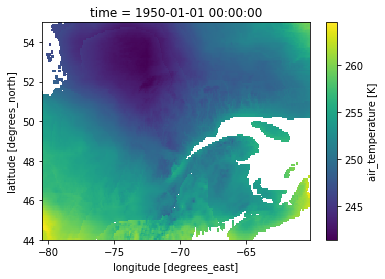

In [104]:
lon_bnds = [-80.5, -60.2]
lat_bnds = [44, 55]

ds1 = subset.subset_bbox(ds, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(ds1)
ds1.tasmax.isel(time=0).plot()

___
### Subsetting using a polygon : `subset.shape()`
* extract data using a GIS polygon layer (geojson, shapefile, or other) 

We will use a polygon layer for Quebec administative regions as a test layer
* User's can upload 

,isSubreg,AreaKm2,Region,Stride,RegType,geometry
0,1,64619.543075,Abitibi-Témiscamingue,1,admin,"MULTIPOLYGON (((-75.52055 49.00002, -75.52064 ..."
1,1,19429.113878,Capitale-Nationale,1,admin,"MULTIPOLYGON (((-70.78151 46.97156, -70.80159 ..."
2,1,7035.163146,Centre-du-Québec,1,admin,"MULTIPOLYGON (((-72.03655 46.55848, -72.03607 ..."
3,1,15267.682927,Chaudière-Appalaches,1,admin,"MULTIPOLYGON (((-70.64336 47.02725, -70.64995 ..."
4,1,10502.393578,Estrie,1,admin,"MULTIPOLYGON (((-70.41361 45.79600, -70.41368 ..."


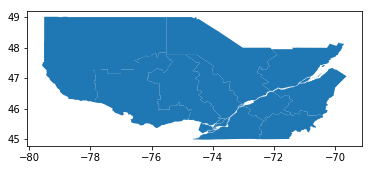

In [100]:
import geopandas as gpd
import matplotlib.pyplot as plt
regions = gpd.GeoDataFrame.from_file('test_regions.geojson')
display(regions.head())
regions.plot()